# Constrained Monotonic Neural Networks

The code is accompaning the paper titled "Constrained Monotonic Neural Networks".

In [2]:
from typing import *

from contextlib import contextmanager

from numpy.typing import ArrayLike, NDArray

import pandas as pd
import numpy as np
from pathlib import Path 

import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow import feature_column as fc
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.python.keras.engine.keras_tensor import KerasTensor

## Data download

Data is downloaded from our S3 bucket. Please do not redistribute the data.

In [3]:
!mkdir data
!cd data; rm *.csv; wget https://neurips2022submission-5600-monotonicnetworks.s3.amazonaws.com/data.zip; unzip data.zip; rm data.zip

!ls -lh data

rm: cannot remove '*.csv': No such file or directory
--2023-01-26 13:14:26--  https://neurips2022submission-5600-monotonicnetworks.s3.amazonaws.com/data.zip
Resolving neurips2022submission-5600-monotonicnetworks.s3.amazonaws.com (neurips2022submission-5600-monotonicnetworks.s3.amazonaws.com)... 54.231.164.41, 52.216.171.43, 3.5.10.10, ...
Connecting to neurips2022submission-5600-monotonicnetworks.s3.amazonaws.com (neurips2022submission-5600-monotonicnetworks.s3.amazonaws.com)|54.231.164.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13805233 (13M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  13.17M  --.-KB/s    in 0.1s    

2023-01-26 13:14:27 (100 MB/s) - ‘data.zip’ saved [13805233/13805233]

Archive:  data.zip
  inflating: train_heart.csv         
  inflating: train_auto.csv          
  inflating: test_heart.csv          
  inflating: test_auto.csv           
  inflating: train_compas.csv        
  inflating: t

A simple check that we have five training and testing datasets downloaded

In [4]:
data_path = Path("data")
assert data_path.exists(), "Please download the data by runnning the cell above"
train_datasets = list(data_path.glob("train_*.csv"))
test_datasets = list(data_path.glob("test_*.csv"))
assert len(train_datasets) == 5, "There should be five train datasets downloaded"
assert len(test_datasets) == 5, "There should be five test datasets downloaded"

# Monotonic Dense Unit Class


### Actvation Functions

In [5]:
def get_saturated_activation(
    convex_activation: Callable[[tf.Tensor], tf.Tensor],
    concave_activation: Callable[[tf.Tensor], tf.Tensor],
    a: float = 1.0,
    c: float = 1.0,
) -> Callable[[tf.Tensor], tf.Tensor]:
    def saturated_activation(
        x: tf.Tensor,
        convex_activation: Callable[[tf.Tensor], tf.Tensor]=convex_activation,
        concave_activation: Callable[[tf.Tensor], tf.Tensor]=concave_activation,
        a: float=a,
        c: float=c,
    ) -> tf.Tensor:
        cc = convex_activation(tf.ones_like(x) * c)
        return a * tf.where(
            x <= c,
            convex_activation(x + c) - cc,
            concave_activation(x - c) + cc,
        )
    
    return saturated_activation
     


def get_activation_functions(
    activation: Optional[Union[str, Callable[[tf.Tensor], tf.Tensor]]] = None
) -> Tuple[
    Optional[Callable[[tf.Tensor], tf.Tensor]],
    Optional[Callable[[tf.Tensor], tf.Tensor]],
    Optional[Callable[[tf.Tensor], tf.Tensor]],
]:
    if activation:
        convex_activation = tf.keras.activations.get(
            activation.lower() if isinstance(activation, str) else activation
        )
        concave_activation = lambda x: -convex_activation(-x)
        saturated_activation = get_saturated_activation(
            convex_activation, concave_activation
        )
        return convex_activation, concave_activation, saturated_activation
    else:
        return None, None, None
     


In [6]:
def apply_activations(
    x: tf.Tensor,
    *,
    units,
    activation: Optional[Union[str, Callable[[tf.Tensor], tf.Tensor]]] = None,
    is_convex: bool = False,
    is_concave: bool = False,
    activation_weights: Tuple[float, float, float] = (1.0, 1.0, 1.0),
) -> tf.Tensor:
    (
        convex_activation,
        concave_activation,
        saturated_activation,
    ) = get_activation_functions(activation)
    
    if convex_activation is None:
        return x
    elif is_convex:
        return convex_activation(x)
    elif is_concave:
        return concave_activation(x)
    else:
        if len(activation_weights) != 3:
            raise ValueError(f"activation_weights={activation_weights}")
        if (np.array(activation_weights) < 0).any():
            raise ValueError(f"activation_weights={activation_weights}")
        normalized_activation_weights = np.array(activation_weights) / sum(activation_weights)
        
        convex_length = round(normalized_activation_weights[0]*units)
        concave_length = round(normalized_activation_weights[1]*units)
        saturated_length = units - convex_length - concave_length
        
        x_convex, x_concave, x_saturated = tf.split(x, (convex_length, concave_length, saturated_length), axis=-1)
       
        y_convex = convex_activation(x_convex)
        y_concave = convex_activation(x_concave)
        y_saturated = saturated_activation(x_saturated)
        
        y = tf.concat([y_convex, y_concave, y_saturated], axis=-1)
        
        return y

## Monotonicity indicator


In [7]:
def check_monotonicity_indicator_values(monotonicity_indicator: Union[int, NDArray[np.int_]]):
    if isinstance(monotonicity_indicator, int):
        if monotonicity_indicator not in [-1, 0, 1]:
            raise ValueError(f"monotonicity_indicator must be one of -1, 0, 1, but it is {monotonicity_indicator} instead!")
    else:
        r = (monotonicity_indicator == -1) | (monotonicity_indicator == 0) | (monotonicity_indicator == 1)
        if not r.all():
            raise ValueError(f"Each element of monotonicity_indicator must be one of -1, 0, 1, but it is {monotonicity_indicator}!")

In [8]:
def apply_monotonicity_indicator_to_kernel(
    kernel: tf.Variable, monotonicity_indicator: Union[int, NDArray[np.int_]]
) -> tf.Tensor:
    abs_kernel = tf.abs(kernel)
    if isinstance(monotonicity_indicator, int):
        if monotonicity_indicator == 1:
            return abs_kernel
        elif monotonicity_indicator == -1:
            return -abs_kernel
        else:
            return kernel
    else:
        if kernel.shape != monotonicity_indicator.shape:
            raise ValueError("Kernel and monotonicity_indicator must have the same shapes, but we have {kernel.shape} != {monotonicity_indicator.shape=}")
#         monotonicity_indicator = np.expand_dims(monotonicity_indicator, axis=-1)
        kernel = tf.where(
            monotonicity_indicator == 1,
            abs_kernel,
            kernel,
        )
        return tf.where(monotonicity_indicator == -1, -abs_kernel, kernel)

## Monotonic Dense Layer

This is an implementation of our Monotonic Dense Unit or Constrained Monotone Fully Connected Layer. The below is the figure from the paper for reference.
In the code, the variable `indicator_vector` corresponds to **t** in the figure and the variable `activation_selector` corresponds to **s**. 

Parameters `convexity_indicator` and `epsilon` are used to calculate `activation_selector` as follows:
- if `convexity_indicator` is  -1 or 1, then `activation_selector` will have all elements 0 or 1, respecively.
- if `convexity_indicator` is `None`, then `epsilon` must have a value between 0 and 1 and corresponds to the percentage of elements of `activation_selector` set to 1.

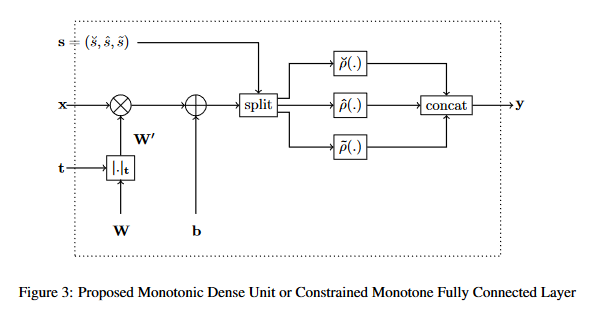

In [9]:
class MonotonicDense(Dense):
    """Monotonic counterpart of the regular Dense Layer of tf.keras"""

    def __init__(
        self,
        units: int,
        *,
        activation: Optional[Union[str, Callable[[tf.Tensor], tf.Tensor]]] = None,
        monotonicity_indicator: Union[int, NDArray[np.int_]] = 1,
        is_convex: bool = False,
        is_concave: bool = False,
        activation_weights: Tuple[float, float, float] = (1.0, 1.0, 1.0),
        **kwargs,
    ):
        """Constructs a new MonotonicDense instance.

        Params:
            units: Positive integer, dimensionality of the output space.
            activation: Activation function to use, it is assumed to be convex monotonically
                increasing function such as "relu" or "elu"
            monotonicity_indicator: Vector to indicate which of the inputs are monotonically increasing or
                monotonically decreasing or non-monotonic. Has value 1 for monotonically increasing,
                -1 for monotonically decreasing and 0 for non-monotonic.
            is_convex: convex if set to True
            is_concave: concave if set to True
            activation_weights: relative weights for each type of activation, the default is (1.0, 1.0, 1.0).
                Ignored if is_convex or is_concave is set to True
            **kwargs: passed directly to the constructor of `Dense`

        Returns:
            N-D tensor with shape: `(batch_size, ..., units)`.

        Raise:
            ValueError:
                - if both **is_concave** and **is_convex** are set to **True**, or
                - if any component of activation_weights is negative or there is not exactly three components
        """
        check_monotonicity_indicator_values(monotonicity_indicator)

        if is_convex and is_concave:
            raise ValueError(
                "The model cannot be set to be both convex and concave (only linear functions are both)."
            )

        if len(activation_weights) != 3:
            raise ValueError(
                f"There must be exactly three components of activation_weights, but we have this instead: {activation_weights}."
            )

        if (np.array(activation_weights) < 0).any():
            raise ValueError(
                f"Values of activation_weights must be non-negative, but we have this instead: {activation_weights}."
            )

        super(MonotonicDense, self).__init__(units, activation=None, **kwargs)

        self.units = units
        self.org_activation = activation
        self.activation_weights = activation_weights
        self.monotonicity_indicator = monotonicity_indicator
        self.is_convex = is_convex
        self.is_concave = is_concave

    @contextmanager
    def replace_kernel(self):
        """Replaces kernel with non-negative or non-positive values according
        to the **monotonicity_indicator**
        """
        kernel_org = self.kernel
        self.kernel = apply_monotonicity_indicator_to_kernel(
            self.kernel, self.monotonicity_indicator
        )
        try:
            yield
        finally:
            self.kernel = kernel_org

    def build(self, input_shape, *args, **kwargs):
        """Build

        Args:
            input_shape: input tensor
        """
        super(MonotonicDense, self).build(input_shape, *args, **kwargs)
        if not isinstance(self.monotonicity_indicator, int):
            if self.kernel.shape != self.monotonicity_indicator.shape:
                raise ValueError(
                    f"Input shape and monotonicity vector don't have matching shapes: {self.kernel.shape} != {self.monotonicity_indicator.shape}"
                )

    def call(self, inputs):
        """Call

        Args:
            inputs: input tensor
        """
        # calculate W'*x+y after we replace the kernal according to monotonicity vector
        with self.replace_kernel():
            y = super(MonotonicDense, self).call(inputs)

        y = apply_activations(
            y,
            units=self.units,
            activation=self.org_activation,
            is_convex=self.is_convex,
            is_concave=self.is_concave,
            activation_weights=self.activation_weights,
        )

        return y

The function `build_monotonic_type1_model()` can be used to build Neural Network models as shown in the figure below and is referred to in the paper as *Neural architecture type 1*. 

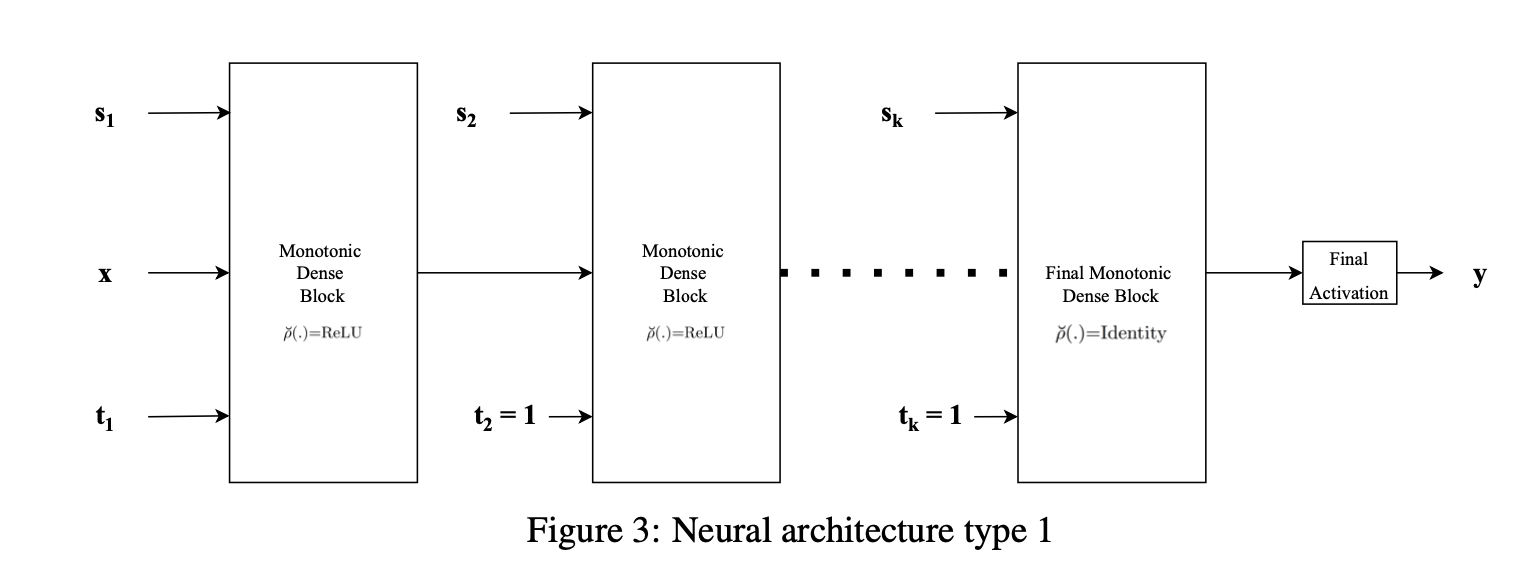

In [10]:
def build_monotonic_type1_model(
    *,
    units: int = 4,
    activation: str = "elu",
    n_layers: int = 2,
    is_classification:bool=True,
    indicator_vector = None,
    convexity_indicator=None,
    col_names=[],
):
    
    # input
    x = [Input(shape=1, name=name) for name in col_names]
    y = tf.keras.layers.concatenate(x)
    

    y = MonotonicDense(
        units=units,
        activation=activation,
        monotonicity_indicator=indicator_vector,
    )(y)

    for _ in range(n_layers - 1):
        y = MonotonicDense(
            units=units,
            activation=activation,
        )(y)

    # final layer has no activation function
    y = MonotonicDense(units=1, activation=None)(y)
    if is_classification:
      y = tf.keras.activations.sigmoid(y)

    
    model = Model(inputs=x, outputs=y)
    return model

The function `build_monotonic_type2_model()` can be used to build Neural Network models as shown in the figure below and is referred to in the paper as *Neural architecture type 2*. 

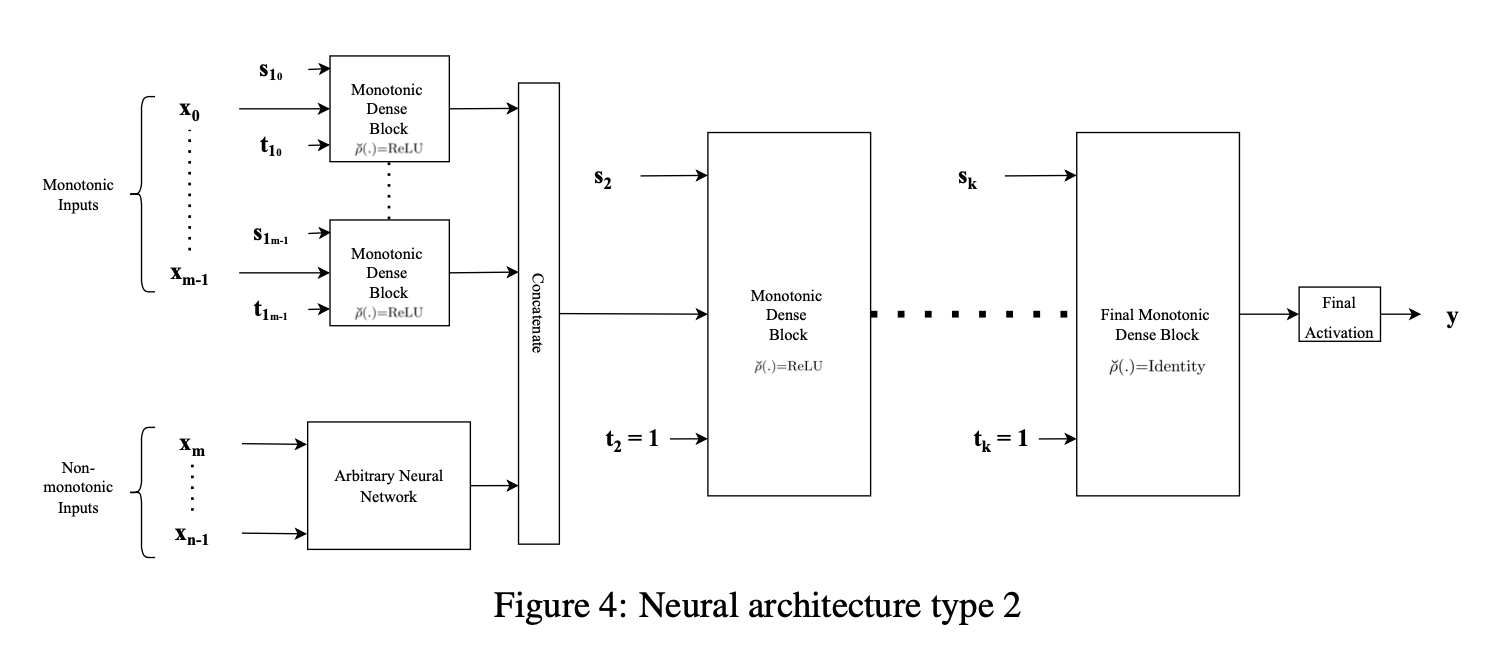

In [11]:
def build_monotonic_type2_model(
  *,
  units: int=4,
  activation: str="elu",
  n_layers: int=2,
  is_classification:bool=True,
  indicator_vector=None,
  convexity_indicator=None,
  col_names=[],
):

    # input
    x = [Input(shape=1, name=name) for name in col_names]

    normalized_x = x  

    mono_dense = [
        MonotonicDense(
            units=units // 4,
            activation=activation,
            monotonicity_indicator=int(indicator_vector[i]),
            # is=convexity_indicator[i] if convexity_indicator is not None else None,
        )(normalized_x[i])
        for i in range(len(x))]

    y = tf.keras.layers.concatenate(mono_dense)


    for _ in range(n_layers - 1):
        y = MonotonicDense(
            units=units,
            activation=activation,
        )(y)

    y = MonotonicDense(units=1, activation=None)(y)
    if is_classification:
      y = tf.keras.activations.sigmoid(y)

    model = Model(inputs=x, outputs=y)

    return model

## Experiments

For our experiments, we employ the datasets used by the authors of Certified Monotonic Network [1] and COMET [2]. We use the exact train-test split provided by the authors. Their respective repositories are linked below in the references. We directly load the saved train-test data split which have been saved after running the codes from respective papers' authors. 


References:


1.   Xingchao Liu, Xing Han, Na Zhang, and Qiang Liu. Certified monotonic neural networks. Advances in Neural Information Processing Systems, 33:15427–15438, 2020
  
  Github repo: https://github.com/gnobitab/CertifiedMonotonicNetwork



2.   Aishwarya Sivaraman, Golnoosh Farnadi, Todd Millstein, and Guy Van den Broeck. Counterexample-guided learning of monotonic neural networks. Advances in Neural Information Processing Systems, 33:11936–11948, 2020

  Github repo: https://github.com/AishwaryaSivaraman/COMET

In [12]:
def get_train_n_test_data(data_path, dataset_name):
  train_filename = "train_"+dataset_name+".csv"
  train_df = pd.read_csv(data_path/train_filename)
  test_filename = "test_"+dataset_name+".csv"
  test_df = pd.read_csv(data_path/test_filename)
  return train_df, test_df

def get_feats_n_gt(df):
  y = df.pop("ground_truth").values
  return df, y


In [13]:
def train_dataset(dataset_name: str, indicator_vector: Optional[NDArray], convexity_indicator: Optional[NDArray], train_params: Dict[str, Any]):

  train_df, test_df=get_train_n_test_data(data_path=data_path, dataset_name=dataset_name)

  train_df, y_train = get_feats_n_gt(train_df)
  test_df, y_test = get_feats_n_gt(test_df)

  col_names= train_df.columns.to_list()
 
  batch_size = train_params["batch_size"]
  num_epochs = train_params["num_epochs"]
  units = train_params["units"]
  n_layers = train_params["n_layers"]
  activation = train_params["activation"]
  loss=train_params["loss"]
  metrics=train_params["metrics"]
  learning_rate=train_params["learning_rate"]
  is_classification=train_params["is_classification"]


  monotonic_model = build_monotonic_type2_model(
      units=units,
      n_layers=n_layers,
      activation=activation,
      is_classification=is_classification,
      col_names=col_names,
      indicator_vector=indicator_vector,
      convexity_indicator=convexity_indicator

  )
  train_ds = tf.data.Dataset.from_tensor_slices((dict(train_df), y_train))
  test_ds = tf.data.Dataset.from_tensor_slices((dict(test_df), y_test))

  train_ds=train_ds.batch(batch_size)
  val_ds=test_ds.batch(batch_size)


  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
  monotonic_model.compile(optimizer=optimizer,loss=loss,metrics=metrics)
  history = monotonic_model.fit(train_ds,validation_data=val_ds,epochs=num_epochs)

  return history, monotonic_model

### Comparison with methods and datasets from COMET [1]


References:


1.   Aishwarya Sivaraman, Golnoosh Farnadi, Todd Millstein, and Guy Van den Broeck. Counterexample-guided learning of monotonic neural networks. Advances in Neural Information Processing Systems, 33:11936–11948, 2020

  Github repo: https://github.com/AishwaryaSivaraman/COMET



#### Experiment for Auto MPG dataset

The Auto MPG Dataset is a regression dataset [1] with 7 features - Cylinders, Displacement, Horsepower,Weight, Acceleration, Model Year, Origin. And the dependant variable is monotonically decreasing with
respect to features weigh, displacement, and horsepower. The `indicator_vector` corrsponding to these features are set to -1, since the relationship is a monotonically decreasing one with respect to the dependant variable.



References:

1. Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning. In Proceedings on the Tenth International Conference of Machine Learning, 236-243, University of Massachusetts, Amherst. Morgan Kaufmann.
 
  https://archive.ics.uci.edu/ml/datasets/auto+mpg

2.   Aishwarya Sivaraman, Golnoosh Farnadi, Todd Millstein, and Guy Van den Broeck. Counterexample-guided learning of monotonic neural networks. Advances in Neural Information Processing Systems, 33:11936–11948, 2020


In [ ]:
indicator_vector = np.array([ 0, -1,  -1,  -1,  0,  0,  0])

convexity_indicator = None

train_params = dict(
    batch_size = 16,
    num_epochs = 20,
    units = 64,
    n_layers = 1,
    activation = "elu",
    loss="mean_squared_error",
    metrics=tf.keras.metrics.RootMeanSquaredError(),
    learning_rate = 0.028,
    is_classification=False,
)

history, monotonic_model =  train_dataset(dataset_name="auto", indicator_vector=indicator_vector, convexity_indicator=convexity_indicator, train_params=train_params)

Epoch 1/20
20/20 [==============================] - 4s 43ms/step - loss: 236.3600 - root_mean_squared_error: 15.3740 - val_loss: 80.3926 - val_root_mean_squared_error: 8.9662
Epoch 2/20
20/20 [==============================] - 0s 15ms/step - loss: 101.5924 - root_mean_squared_error: 10.0793 - val_loss: 36.8824 - val_root_mean_squared_error: 6.0731
Epoch 3/20
20/20 [==============================] - 0s 10ms/step - loss: 17.3473 - root_mean_squared_error: 4.1650 - val_loss: 11.2201 - val_root_mean_squared_error: 3.3496
Epoch 4/20
20/20 [==============================] - 0s 12ms/step - loss: 11.8605 - root_mean_squared_error: 3.4439 - val_loss: 11.3601 - val_root_mean_squared_error: 3.3705
Epoch 5/20
20/20 [==============================] - 0s 18ms/step - loss: 13.5775 - root_mean_squared_error: 3.6848 - val_loss: 11.1771 - val_root_mean_squared_error: 3.3432
Epoch 6/20
20/20 [==============================] - 0s 19ms/step - loss: 12.5268 - root_mean_squared_error: 3.5393 - val_loss: 10.8

#### Experiment for  Heart Disease  Dataset [1]



Heart Disease [1] is a classification dataset
used for predicting the presence of heart disease with 13 features (age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal)   and monotonically increasing with respect to features- trestbps and cholestrol (chol). The `indicator_vector` corrsponding to these features are set to 1. 



References:


1.   John H. Gennari, Pat Langley, and Douglas H. Fisher. Models of incremental concept formation. Artif. Intell., 40(1-3):11–61, 1989.

  https://archive.ics.uci.edu/ml/datasets/heart+disease

2.   Aishwarya Sivaraman, Golnoosh Farnadi, Todd Millstein, and Guy Van den Broeck. Counterexample-guided learning of monotonic neural networks. Advances in Neural Information Processing Systems, 33:11936–11948, 2020



In [ ]:
indicator_vector =  np.array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

convexity_indicator = None

train_params = dict(
    batch_size = 32,
    num_epochs = 1,
    units = 32,
    n_layers = 1,
    activation = "elu",
    loss="binary_crossentropy",
    metrics="accuracy",
    learning_rate = 0.01,
    is_classification=True,

)

history, monotonic_model =  train_dataset(dataset_name="heart", indicator_vector=indicator_vector, convexity_indicator=convexity_indicator, train_params=train_params)

8/8 [==============================] - 9s 243ms/step - loss: 0.6256 - accuracy: 0.6322 - val_loss: 0.4479 - val_accuracy: 0.8689


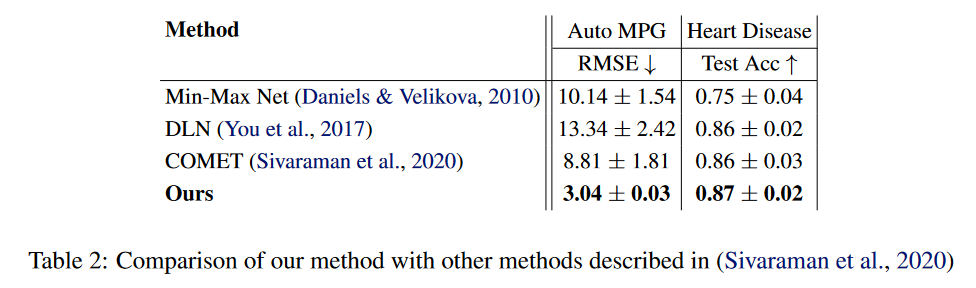

The figure above shows the table from our paper for reference. As can be seen from our experiments above, our proposed methodology performs comparable to or better than state-of-the-art

### Comparison with methods and datasets from Certified Monotonic Network [1] 


References:


1.   Xingchao Liu, Xing Han, Na Zhang, and Qiang Liu. Certified monotonic neural networks. Advances in Neural Information Processing Systems, 33:15427–15438, 2020



#### Experiment for Compas Dataset [1]

COMPAS [1] is a dataset containing the criminal records of 6,172 individuals
arrested in Florida. The task is to predict whether the individual will commit a crime again
in 2 years. The probability predicted by the system will be used as a risk score. As mentioned in [2] 13 attributes for prediction. The risk score should be monotonically increasing w.r.t. four attributes, number of prior adult convictions, number of juvenile felony, number of juvenile misdemeanor, and number of other convictions. The `indicator_vector` corrsponding to these features are set to 1.

References: 

1. S. Mattu J. Angwin, J. Larson and L. Kirchner. Machine bias: There’s software used across the country to predict future criminals. and it’s biased against blacks. ProPublica, 2016.

2. Xingchao Liu, Xing Han, Na Zhang, and Qiang Liu. Certified monotonic neural networks. Advances in Neural Information Processing Systems, 33:15427–15438, 2020


In [14]:
indicator_vector = np.array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

convexity_indicator = None

train_params = dict(
    batch_size = 64,
    num_epochs = 2,
    units = 16,
    n_layers = 2,
    activation = "relu",
    loss="binary_crossentropy",
    metrics="accuracy",
    learning_rate = 0.028,
    is_classification=True,

)


history, monotonic_model =  train_dataset(dataset_name="compas", indicator_vector=indicator_vector, convexity_indicator=convexity_indicator, train_params=train_params)

Epoch 1/2
78/78 [==============================] - 6s 16ms/step - loss: 0.6409 - accuracy: 0.6340 - val_loss: 0.6122 - val_accuracy: 0.6640
Epoch 2/2
78/78 [==============================] - 1s 10ms/step - loss: 0.6165 - accuracy: 0.6628 - val_loss: 0.6038 - val_accuracy: 0.6899


#### Experiment for Blog Dataset [1]

Blog Feedback [1] is a dataset containing 54,270 data points from
blog posts. The raw HTML-documents of the blog posts were crawled and processed. The prediction
task associated with the data is the prediction of the number of comments in the upcoming 24 hours.
The feature of the dataset has 276 dimensions, and 8 attributes among them should be monotonically
non-decreasing with the prediction. They are A51, A52, A53, A54, A56, A57, A58, A59. Thus the `indicator_vector` corrsponding to these features are set to 1.  As done in [2], we only use the data points with targets smaller than the 90th percentile.




References:

1.   Krisztian Buza. Feedback prediction for blogs. In Data analysis, machine learning and knowledge discovery, pages 145–152. Springer, 2014
2.   Xingchao Liu, Xing Han, Na Zhang, and Qiang Liu. Certified monotonic neural networks. Advances in Neural Information Processing Systems, 33:15427–15438, 2020



In [ ]:
indicator_vector = np.zeros((276))
indicator_vector[50:54] = 1.0
indicator_vector[55:59] = 1.0

convexity_indicator = None

train_params = dict(
  batch_size = 256,
  num_epochs = 100,
  units = 4,
  n_layers = 2,
  activation = "elu",
  loss="mean_squared_error",
  metrics=tf.keras.metrics.RootMeanSquaredError(),
  learning_rate = 0.01,
  is_classification=False,

)





history, monotonic_model =  train_dataset(dataset_name="blog", indicator_vector=indicator_vector, convexity_indicator=convexity_indicator, train_params=train_params)


Epoch 1/100
185/185 [==============================] - 96s 188ms/step - loss: 0.0383 - root_mean_squared_error: 0.1957 - val_loss: 0.0356 - val_root_mean_squared_error: 0.1888
Epoch 2/100
185/185 [==============================] - 20s 109ms/step - loss: 0.0366 - root_mean_squared_error: 0.1914 - val_loss: 0.0352 - val_root_mean_squared_error: 0.1876
Epoch 3/100
185/185 [==============================] - 20s 110ms/step - loss: 0.0363 - root_mean_squared_error: 0.1906 - val_loss: 0.0325 - val_root_mean_squared_error: 0.1804
Epoch 4/100
185/185 [==============================] - 21s 115ms/step - loss: 0.0372 - root_mean_squared_error: 0.1928 - val_loss: 0.0315 - val_root_mean_squared_error: 0.1776
Epoch 5/100
185/185 [==============================] - 20s 110ms/step - loss: 0.0356 - root_mean_squared_error: 0.1887 - val_loss: 0.0310 - val_root_mean_squared_error: 0.1760
Epoch 6/100
185/185 [==============================] - 20s 110ms/step - loss: 0.0346 - root_mean_squared_error: 0.1860 -

#### Experiment for Loan  Dataset [1]

Lending club loan *data*
contains complete loan data for all loans
issued through 2007-2015 of several banks. Each data point is a 28-dimensional feature including
the current loan status, latest payment information, and other additional features. The task is to
predict loan defaulters given the feature vector. The possibility of loan default should be nondecreasing w.r.t. number of public record bankruptcies, Debt-to-Income ratio, and
non-increasing w.r.t. credit score, length of employment, annual income. Thus the `indicator_vector` corrsponding to these features are set to 1.


References:

1. https://www.kaggle.com/wendykan/lending-club-loan-data (Note: Currently, the dataset seems to be withdrawn from kaggle)

In [16]:
indicator_vector = np.array([-1,  1, -1, -1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])


convexity_indicator = None

train_params = dict(
    batch_size = 256,
    num_epochs = 20,
    units = 4,
    n_layers = 1,
    activation = "elu",
    loss="binary_crossentropy",
    metrics="accuracy",
    learning_rate = 0.008,
    is_classification=True,)


history, monotonic_model =  train_dataset(dataset_name="loan", indicator_vector=indicator_vector, convexity_indicator=convexity_indicator, train_params=train_params)

Epoch 1/20
1636/1636 [==============================] - 30s 16ms/step - loss: 0.6313 - accuracy: 0.6417 - val_loss: 0.6260 - val_accuracy: 0.6467
Epoch 2/20
1636/1636 [==============================] - 25s 15ms/step - loss: 0.6274 - accuracy: 0.6452 - val_loss: 0.6250 - val_accuracy: 0.6474
Epoch 3/20
1636/1636 [==============================] - 26s 16ms/step - loss: 0.6267 - accuracy: 0.6461 - val_loss: 0.6243 - val_accuracy: 0.6490
Epoch 4/20
1636/1636 [==============================] - 25s 15ms/step - loss: 0.6264 - accuracy: 0.6466 - val_loss: 0.6240 - val_accuracy: 0.6493
Epoch 5/20
1636/1636 [==============================] - 25s 15ms/step - loss: 0.6262 - accuracy: 0.6467 - val_loss: 0.6239 - val_accuracy: 0.6495
Epoch 6/20
1636/1636 [==============================] - 25s 15ms/step - loss: 0.6261 - accuracy: 0.6469 - val_loss: 0.6239 - val_accuracy: 0.6497
Epoch 7/20
1636/1636 [==============================] - 25s 16ms/step - loss: 0.6261 - accuracy: 0.6470 - val_loss: 0.6238 -

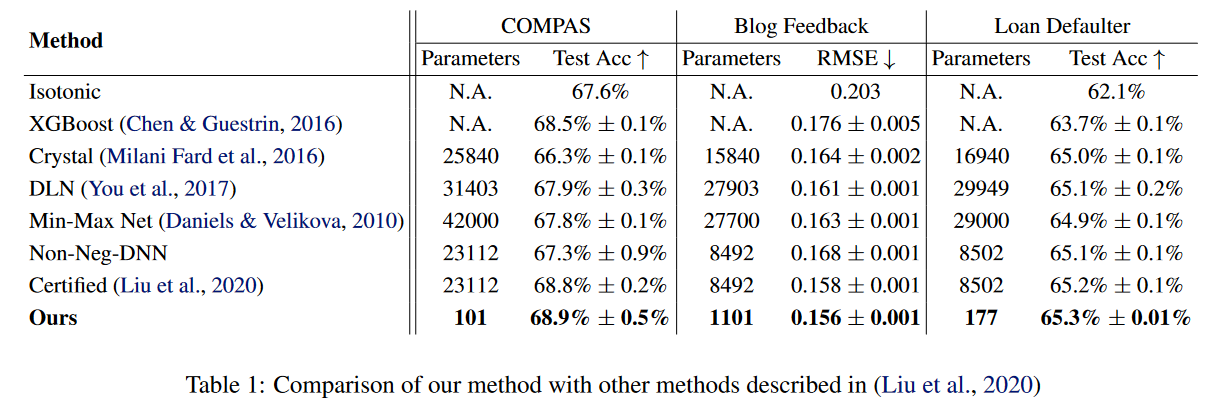

The figure above shows the table from our paper for reference. As can be seen from our experiments above, our proposed methodology performs comparable to or better than state-of-the-art